In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from PIL import Image
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten,Input,concatenate,UpSampling2D
from google.colab import drive
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Downlaoding & Preprocessing are done in: download-data.ipynb; pre-processing.ipynb; process.ipynb

In [ ]:
with open('/content/drive/MyDrive/650-fin/train/trainTest.npy', 'rb') as f:
    X = np.load(f)
    y = np.load(f)

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model((256,256), 2)
model.summary()

In [ ]:
xtr,xte,ytr,yte = train_test_split(X,y, train_size=0.7,random_state=333)
ytrBinarization = (ytr/255).astype(int)

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",metrics=["accuracy"])
epochs = 1

In [ ]:
model.fit(xtr,ytrBinarization, validation_split=0.2,batch_size=35, epochs=epochs)

361/361 [==============================] - 1490s 4s/step - loss: 0.3057 - accuracy: 0.9195 - val_loss: 0.2746 - val_accuracy: 0.9342


In [ ]:
model.fit(xtr,ytrBinarization, validation_split=0.2,batch_size=20, epochs=epochs)

631/631 [==============================] - 1556s 2s/step - loss: 0.1913 - accuracy: 0.9350 - val_loss: 0.2275 - val_accuracy: 0.9352


In [ ]:
model.fit(xtr,ytrBinarization, validation_split=0.2,batch_size=10, epochs=epochs)

1262/1262 [==============================] - 1651s 1s/step - loss: 0.1787 - accuracy: 0.9366 - val_loss: 0.1793 - val_accuracy: 0.9368


In [ ]:
epochs = 35
mdl_tr = model.fit(xtr,ytrBinarization, validation_split=0.2,batch_size=10, epochs=epochs)

Epoch 1/35
1262/1262 [==============================] - 1445s 1s/step - loss: 0.2286 - accuracy: 0.9303 - val_loss: 0.1833 - val_accuracy: 0.9362
Epoch 2/35
1262/1262 [==============================] - 1482s 1s/step - loss: 0.1748 - accuracy: 0.9368 - val_loss: 0.1806 - val_accuracy: 0.9359
Epoch 3/35
1262/1262 [==============================] - 1528s 1s/step - loss: 0.1630 - accuracy: 0.9392 - val_loss: 0.1627 - val_accuracy: 0.9400
Epoch 4/35
1262/1262 [==============================] - 1530s 1s/step - loss: 0.1525 - accuracy: 0.9415 - val_loss: 0.1483 - val_accuracy: 0.9425
Epoch 5/35
1262/1262 [==============================] - 1648s 1s/step - loss: 0.1437 - accuracy: 0.9437 - val_loss: 0.1872 - val_accuracy: 0.9408
Epoch 6/35
1262/1262 [==============================] - 1671s 1s/step - loss: 0.1362 - accuracy: 0.9456 - val_loss: 0.1623 - val_accuracy: 0.9329
Epoch 7/35
1262/1262 [==============================] - 1574s 1s/step - loss: 0.1298 - accuracy: 0.9472 - val_loss: 0.1336 -

Text(0.5, 0, 'epochs')

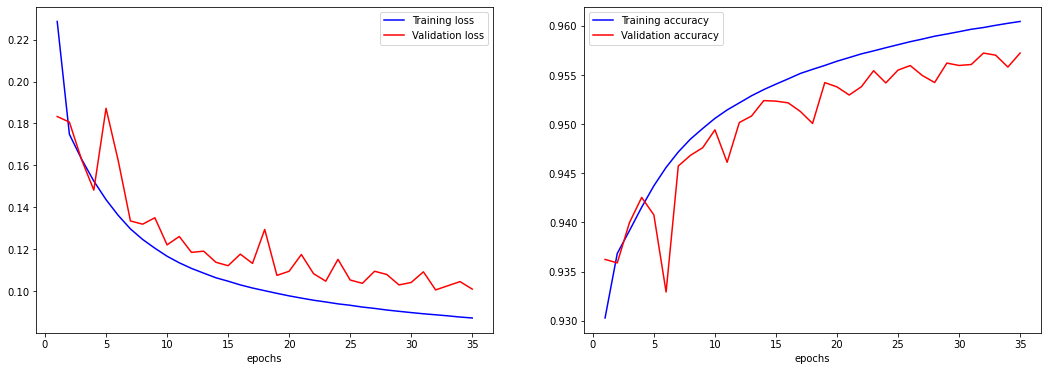

In [ ]:
## Plot the learning stats
NUM_EPOCH = epochs = 35
fig, ax = plt.subplots(1,2, figsize=[18,6])
ax[0].plot(range(1, NUM_EPOCH+1), mdl_tr.history['loss'], c='blue', label='Training loss')
ax[0].plot(range(1, NUM_EPOCH+1), mdl_tr.history['val_loss'], c='red', label='Validation loss')
ax[0].legend()
ax[0].set_xlabel('epochs')

ax[1].plot(range(1, NUM_EPOCH+1), mdl_tr.history['accuracy'], c='blue', label='Training accuracy')
ax[1].plot(range(1, NUM_EPOCH+1), mdl_tr.history['val_accuracy'], c='red', label='Validation accuracy')
ax[1].legend()
ax[1].set_xlabel('epochs')


In [ ]:
# model.save('/content/drive/MyDrive/650-fin/modelSave0429')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/650-fin/modelSave0429/assets


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/650-fin/modelSave0429')

In [ ]:
yteBinarization = (yte/255).astype(int)

In [ ]:
_, accuracy = model.evaluate(xte, yteBinarization, verbose=0)
print(f'Accuracy: {accuracy*100} %')

Accuracy: 95.92076539993286 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 6760 + 1) instead
  


Text(0.5, 1.0, 'UNet Building Outline')

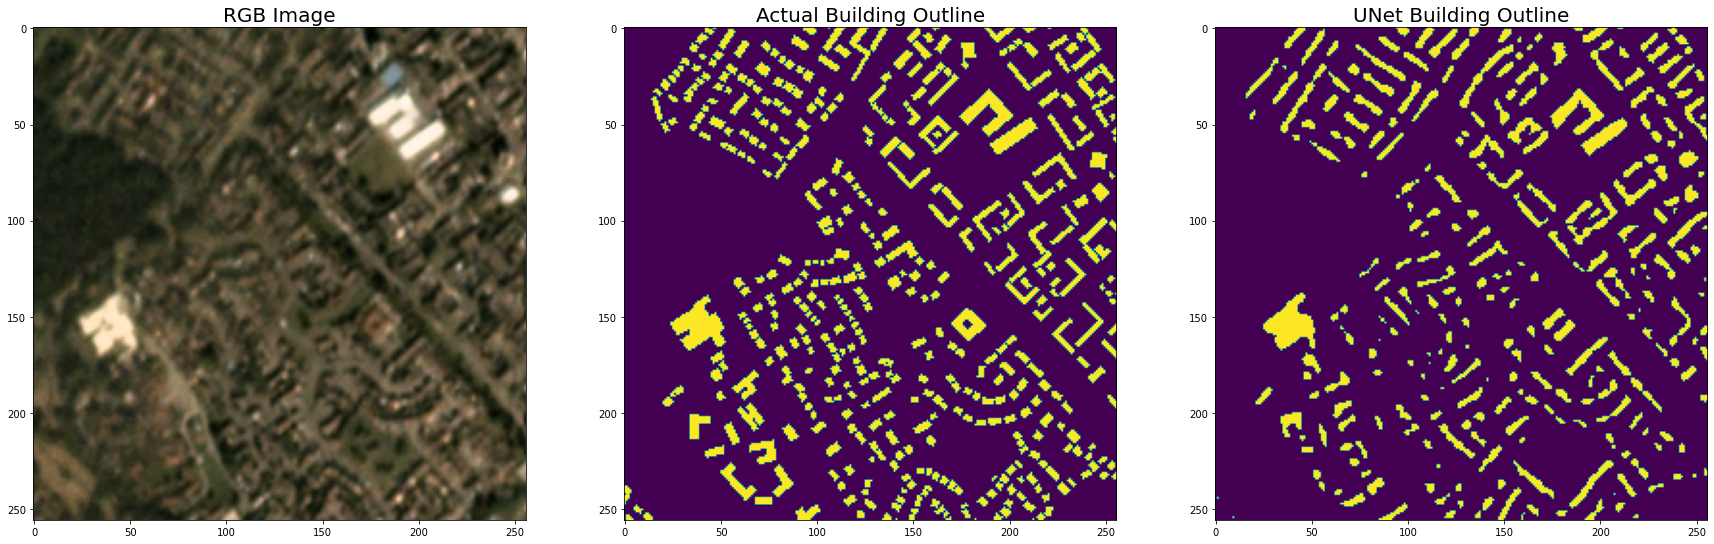

In [ ]:
from IPython.core.pylabtools import figsize
img= np.random.random_integers(0,6760)
#2233
#6472
fig, ax = plt.subplots(1,3, figsize=(30,10))
ax[0].imshow(xte[img][:,:,::-1])
ax[0].set_title("RGB Image",fontsize=20)
ax[1].imshow(yte[img])
ax[1].set_title("Actual Building Outline",fontsize=20)
ax[2].imshow(np.argmax(model.predict(xte[img:img+1,:,:,:])[0],axis=-1))
ax[2].set_title("UNet Building Outline",fontsize=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 6760 + 1) instead
  """


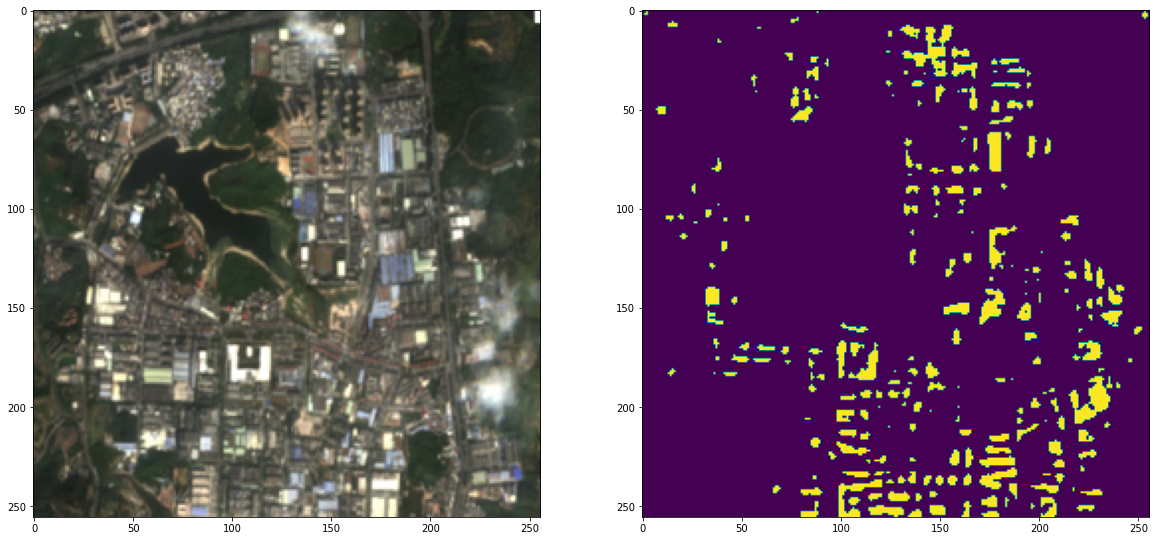

In [ ]:
tmpRGB = Image.open('/content/drive/MyDrive/650-fin/selfTest/dg.png')
tmpRGB = tmpRGB.convert('RGB')
tmpRGB = tmpRGB.resize((256,256))
tmpRGB = np.asarray(tmpRGB)[:,:,::-1].astype(np.uint8)
img=np.random.random_integers(0,6760)
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(tmpRGB[:,:,::-1])
ax[1].imshow(np.argmax(model.predict(tmpRGB.reshape(1,256,256,3))[0],axis=-1))

# Application

In [ ]:
with open('/content/drive/MyDrive/650-fin/0697.npy', 'rb') as f:
    appData = np.load(f)
    date = np.load(f)

In [ ]:
segment = model.predict(appData)
segment = np.argmax(segment,axis=-1)
segment.shape

In [ ]:
bigPic = []
for i in range(25):
  temp = []
  for j in range(4):
    n=i*16+4*j
    med = np.hstack((segment[n],segment[n+1],segment[n+2],segment[n+3]))
    temp.append(med)
  temp = np.vstack(temp)
  bigPic.append(temp)

In [ ]:
with open('/content/drive/MyDrive/650-fin/0697_application.npy', 'wb') as f:
    np.save(f,bigPic)
    np.save(f,date)

In [ ]:
fps = "/content/drive/MyDrive/650-fin/SN7_buildings_test_public/test_public/L15-0697E-0874N_2789_4694_13/images_masked/"
path = []
for fp in os.listdir(fps):
  imgpath = fps+fp
  path.append(imgpath)

for i in range(25):
  tmpRGB = Image.open(path[i])
  tmpRGB = tmpRGB.convert('RGB')
  tmpRGB = np.asarray(tmpRGB).astype(np.uint8)
  fig, ax = plt.subplots(1,2, figsize=(20,10))
  ax[0].imshow(tmpRGB)
  plt.suptitle("Raw satellite image and UNet prediction in "+ str(date[i*16]).split("_")[1] +"/"+str(date[i*16]).split("_")[0] + ", Asunción, Paraguay",fontsize=20, y=0.91)
  ax[1].imshow(bigPic[i])
  plt.savefig("/content/drive/MyDrive/650-fin/gif/"+str(date[i*16])+".jpg",dpi=150)